In [8]:
from deeprxn.featurizer import make_featurizer
from deeprxn.utils import set_seed
import networkx as nx
import matplotlib.patches as patches
from torch_geometric.utils import subgraph
from deeprxn.data import AtomOriginType
from omegaconf import OmegaConf
from hydra import initialize, compose
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.colors as mcolors
import hydra
import os
os.chdir('..')

# TODO: write script that automatically visualizes graph of given config
### TODO: update code

In [9]:
with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    OmegaConf.set_struct(cfg, False)
    #print(OmegaConf.to_yaml(cfg))

set_seed(cfg.seed)
cfg.features.atom_featurizer = "atom_rdkit_organic"
cfg.features.bond_featurizer = "bond_rdkit_base"
atom_featurizer = make_featurizer(cfg.features.atom_featurizer)
bond_featurizer = make_featurizer(cfg.features.bond_featurizer)
cfg.data.dataset_name = "barriers_e2" # "barriers_e2", "barriers_rdb7"
cfg.transformation.representation = "connected_pair" # connected_pair, CGR
cfg.transformation.connection_direction = "bidirectional" # None, bidirectional, reactants_to_products, products_to_reactants

train_loader = hydra.utils.instantiate(
    cfg.transformation, shuffle=True, split="train"
)
data = next(iter(train_loader))[0]

InstantiationException: Error in call to target 'deeprxn.data.construct_loader':
FileNotFoundError(2, 'No such file or directory')
full_key: transformation

### Model

In [3]:
# Adjust model settings
cfg.model.num_node_features = train_loader.dataset.num_node_features
cfg.model.num_edge_features = train_loader.dataset.num_edge_features
cfg.model.depth = 3
cfg.model.hidden_size = 300
cfg.model.dropout = 0.02
cfg.model.pool_type = "global"

model = hydra.utils.instantiate(cfg.model)
print(model)

GNN(
  (edge_init): Linear(in_features=55, out_features=300, bias=True)
  (conv): DMPNNConv()
  (convs): ModuleList(
    (0-2): 3 x DMPNNConv()
  )
  (edge_to_node): Linear(in_features=344, out_features=300, bias=True)
  (ffn): Sequential(
    (0): Dropout(p=0.02, inplace=False)
    (1): Linear(in_features=300, out_features=300, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.02, inplace=False)
    (4): Linear(in_features=300, out_features=1, bias=True)
  )
)


### An example

In [10]:
sample = data

print(f"Node features [num_atoms, num_atom_feat]: {sample.x.shape}")
print(f"Edge index [2, num_bond]: {sample.edge_index.shape}")
print(f"Edge attributes [num_bond, num_bond_feat]: {sample.edge_attr.shape}")
print(f"Target label: {sample.y.shape}")
print(f"Atom origin type: {sample.atom_origin_type.shape}")
print(f"Is real bond: {sample.is_real_bond.shape}, real bonds: {sample.is_real_bond.sum()}, fake bonds: {(~sample.is_real_bond).sum()}")

Node features [num_atoms, num_atom_feat]: torch.Size([26, 44])
Edge index [2, num_bond]: torch.Size([2, 68])
Edge attributes [num_bond, num_bond_feat]: torch.Size([68, 11])
Target label: torch.Size([1])
Atom origin type: torch.Size([26])
Is real bond: torch.Size([68]), real bonds: 42, fake bonds: 26


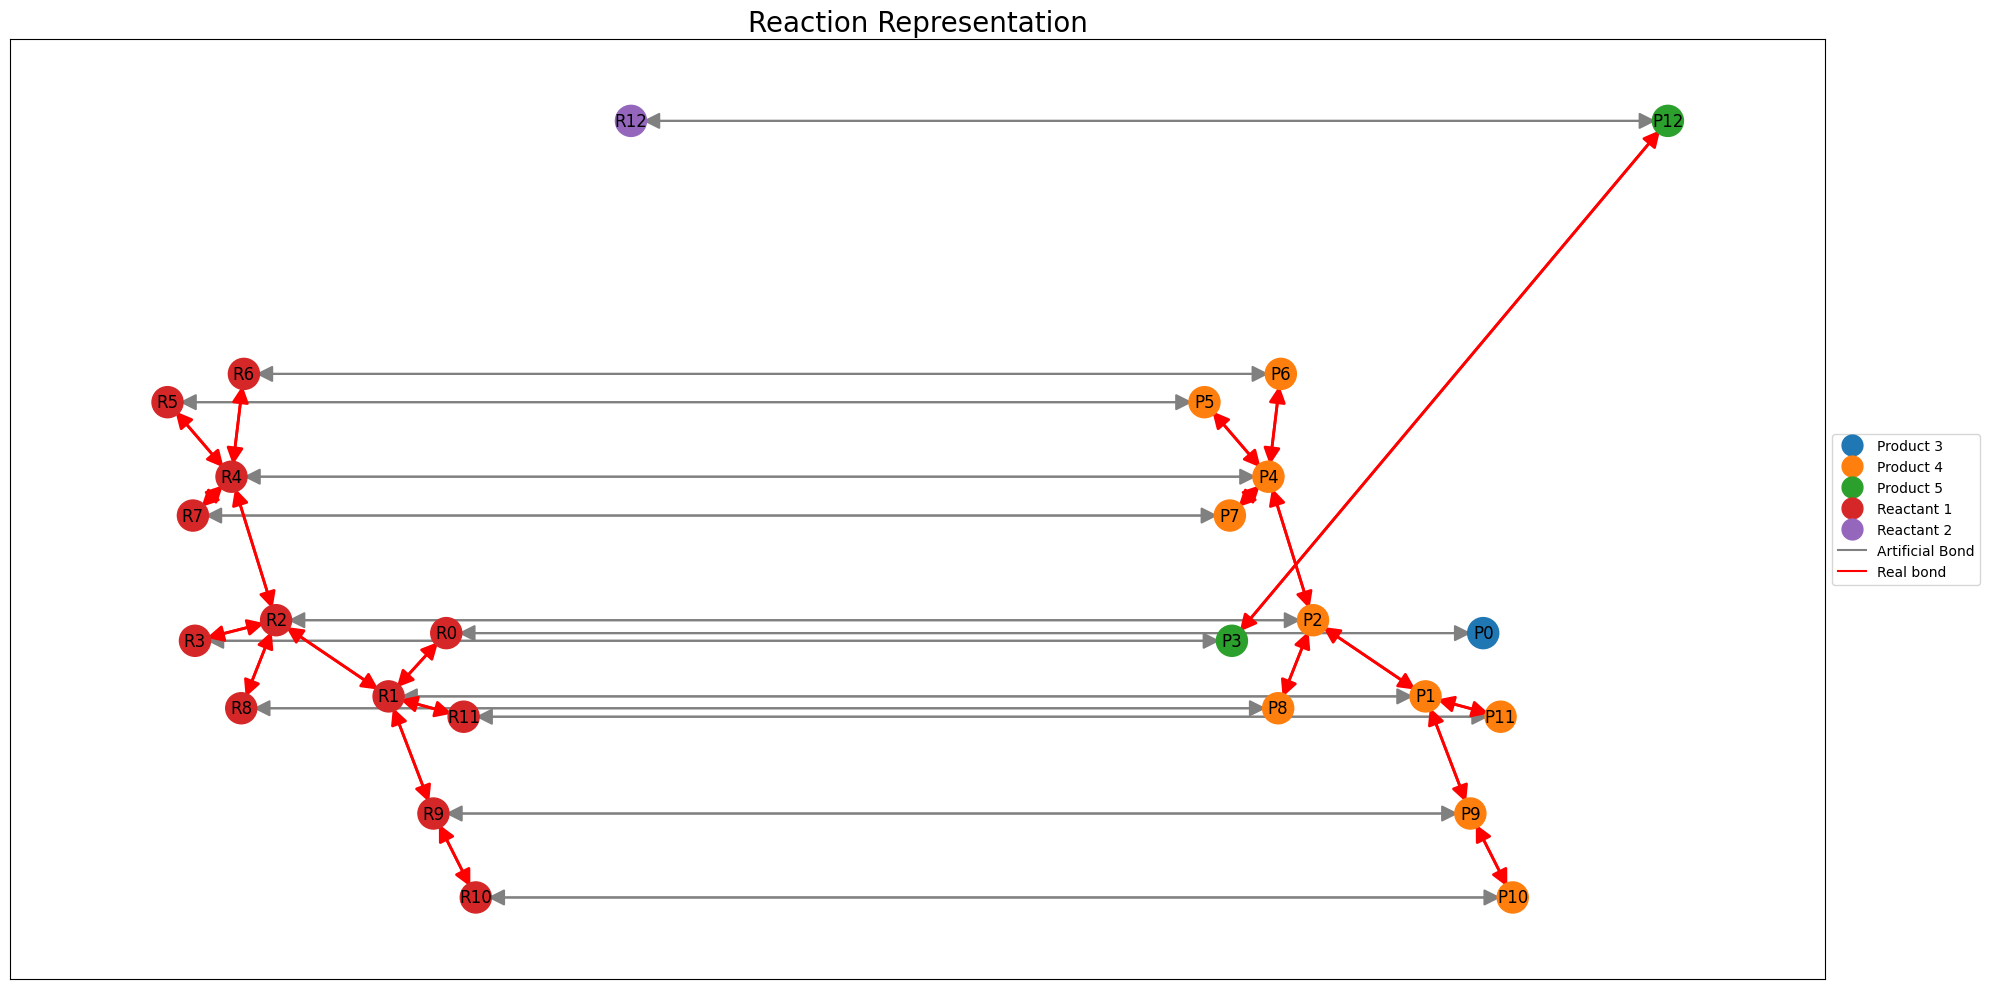

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import matplotlib.colors as mcolors
from torch_geometric.utils import subgraph

def generate_color_palette(n):
    base_colors = list(mcolors.TABLEAU_COLORS.values())
    return base_colors * (n // len(base_colors) + 1)

def split_data(data):
    reactant_mask = data.atom_origin_type == AtomOriginType.REACTANT
    product_mask = data.atom_origin_type == AtomOriginType.PRODUCT
    
    reactants = data.clone()
    reactants.x = data.x[reactant_mask]
    reactants.edge_index, reactants.edge_attr = subgraph(reactant_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    products = data.clone()
    products.x = data.x[product_mask]
    products.edge_index, products.edge_attr = subgraph(product_mask, data.edge_index, data.edge_attr, relabel_nodes=True)
    
    return reactants, products

def create_graph(data):
    G = nx.DiGraph()
    G.add_nodes_from(range(data.x.size(0)))
    edge_index = data.edge_index.t().tolist()
    G.add_edges_from(edge_index)
    return G

def position_nodes(G_reactants, G_products, G_full):
    pos_reactants = nx.spring_layout(G_reactants, seed=42)
    
    max_x = max(pos[0] for pos in pos_reactants.values())
    
    shift = max_x + 2.0
    
    pos_products = {node + len(G_reactants): (x + shift, y) for node, (x, y) in pos_reactants.items()}
    
    pos_combined = pos_reactants.copy()
    pos_combined.update(pos_products)
    
    dummy_nodes = [node for node in G_full.nodes() if data.atom_origin_type[node] == AtomOriginType.DUMMY]
    if dummy_nodes:
        dummy_x_center = (max_x + shift) / 2
        dummy_y = 0
        dummy_x_spread = 0.2
        for i, dummy_node in enumerate(dummy_nodes):
            offset = (i - (len(dummy_nodes) - 1) / 2) * dummy_x_spread
            pos_combined[dummy_node] = (dummy_x_center + offset, dummy_y)
    
    return pos_combined

def visualize_graphs(data):
    reactants, products = split_data(data)

    G_reactants = create_graph(reactants)
    G_products = create_graph(products)
    G_full = create_graph(data)

    pos_combined = position_nodes(G_reactants, G_products, G_full)

    fig, ax = plt.subplots(figsize=(20, 10))

    atom_groups = []
    for atom_type, atom_origin in zip(data.atom_origin_type, data.atom_origins):
        if atom_type == AtomOriginType.DUMMY:
            atom_groups.append('Dummy')
        elif atom_type == AtomOriginType.REACTANT:
            atom_groups.append(f'Reactant {atom_origin + 1}')
        else:
            atom_groups.append(f'Product {atom_origin + 1}')

    unique_groups = sorted(set(atom_groups))
    color_palette = generate_color_palette(len(unique_groups))
    color_map = dict(zip(unique_groups, color_palette))
    
    node_color_map = [color_map[group] for group in atom_groups]

    nx.draw_networkx_nodes(G_full, pos_combined, ax=ax, node_color=node_color_map, node_size=500)

    labels = {}
    reactant_count = 0
    product_count = 0
    dummy_count = 0
    for i, atom_type in enumerate(data.atom_origin_type):
        if atom_type == AtomOriginType.DUMMY:
            labels[i] = f'D{dummy_count}'
            dummy_count += 1
        elif atom_type == AtomOriginType.REACTANT:
            labels[i] = f'R{reactant_count}'
            reactant_count += 1
        else:
            labels[i] = f'P{product_count}'
            product_count += 1

    nx.draw_networkx_labels(G_full, pos_combined, labels, ax=ax, font_size=12)

    non_real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if not real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=non_real_edges, edge_color='gray', arrows=True, arrowsize=25, width=1.5)

    real_edges = [(u, v) for (u, v), real in zip(data.edge_index.t().tolist(), data.is_real_bond) if real]
    nx.draw_networkx_edges(G_full, pos_combined, ax=ax, edgelist=real_edges, edge_color='r', arrows=True, arrowsize=25, width=2)

    for group, color in color_map.items():
        ax.plot([], [], color=color, marker='o', markersize=15, linestyle='', label=group)
    ax.plot([], [], 'gray', label='Artificial Bond')
    ax.plot([], [], 'r-', label='Real bond')
    
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_title("Reaction Representation", fontsize=20)
    plt.tight_layout()
    plt.show()

visualize_graphs(sample)

In [62]:
# class RxnGraph:
#     # TODO: add docstring
#     # TODO (maybe): add support for unbalanced reactions?
#     def __init__(
#         self,
#         smiles,
#         atom_featurizer,
#         bond_featurizer,
#         representation="CGR",
#         connection_direction="bidirectional",
#         dummy_node=None,
#         dummy_connection="to_dummy",
#         dummy_dummy_connection="bidirectional",
#         dummy_feat_init="zeros",
#     ):
from deeprxn.data import MolGraph
import torch
from rdkit import Chem

def make_mol(smi):
    params = Chem.SmilesParserParams()
    params.removeHs = False
    return Chem.MolFromSmiles(smi,params)

class MolGraph:
    def __init__(self, smiles, atom_featurizer, bond_featurizer):
        self.smiles = smiles
        self.f_atoms = []
        self.f_bonds = []
        self.edge_index = []

        mol = make_mol(self.smiles)
        n_atoms=mol.GetNumAtoms()

        for a1 in range(n_atoms):
            f_atom = atom_featurizer(mol.GetAtomWithIdx(a1))
            self.f_atoms.append(f_atom)

            for a2 in range(a1 + 1, n_atoms):
                bond = mol.GetBondBetweenAtoms(a1, a2)
                if bond is None:
                    continue
                f_bond = bond_featurizer(bond)
                self.f_bonds.append(f_bond)
                self.f_bonds.append(f_bond)
                self.edge_index.extend([(a1, a2), (a2, a1)])

molgraph_1 = MolGraph("[H][O][H]", atom_featurizer, bond_featurizer)
edge_index_1 = torch.tensor(molgraph_1.edge_index, dtype=torch.long).t().contiguous()
print(edge_index_1)

edge_attr_1 = torch.tensor([[0.111,0.156,0.0],
                          [0.222,0.199,0.0],
                          [0.0,0.0,0.133],
                          [0.0,0.288,0.0]], dtype=torch.float)
print(edge_attr_1)

molgraph_2 = MolGraph("[H][O]", atom_featurizer, bond_featurizer)
edge_index_2 = torch.tensor(molgraph_2.edge_index, dtype=torch.long).t().contiguous()
edge_index_2 += 3
print(edge_index_2)

edge_attr_2 = torch.tensor([[0.888,0.666,0.0],
                          [0.444,0.999,0.0]], dtype=torch.float)
print(edge_attr_2)

# merge two graphs
edge_index = torch.cat([edge_index_1, edge_index_2], dim=1)
edge_attr = torch.cat([edge_attr_1, edge_attr_2], dim=0)
print(edge_index)
print(edge_attr)

tensor([[0, 1, 1, 2],
        [1, 0, 2, 1]])
tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000]])
tensor([[3, 4],
        [4, 3]])
tensor([[0.8880, 0.6660, 0.0000],
        [0.4440, 0.9990, 0.0000]])
tensor([[0, 1, 1, 2, 3, 4],
        [1, 0, 2, 1, 4, 3]])
tensor([[0.1110, 0.1560, 0.0000],
        [0.2220, 0.1990, 0.0000],
        [0.0000, 0.0000, 0.1330],
        [0.0000, 0.2880, 0.0000],
        [0.8880, 0.6660, 0.0000],
        [0.4440, 0.9990, 0.0000]])
